<a href="https://colab.research.google.com/github/juampamuc/notebooks/blob/main/Agentic_RAG_with_chonkie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦛 Chonkie: Agentic RAG with 🤗 SmolAgents on Chonkie Docs!

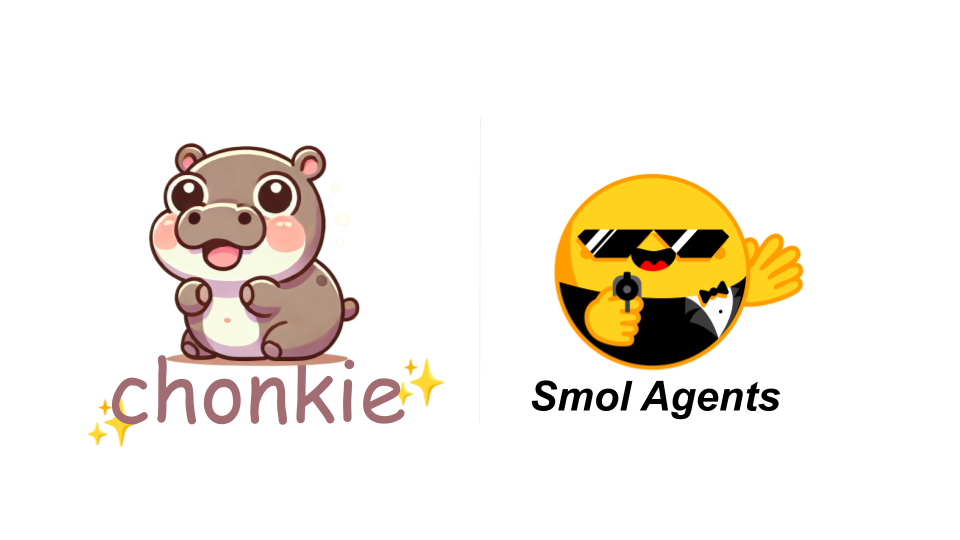

In this notebook, we will see how one can easily use Chonkie to enable Agentic RAG on any documents with the help of 🤗 SmolAgents.


In [ ]:
!git clone https://github.com/chonkie-inc/chonkie.git

Cloning into '/content/chonkie'...
remote: Enumerating objects: 9378, done.
remote: Counting objects: 100% (3071/3071), done.
remote: Compressing objects: 100% (887/887), done.
remote: Total 9378 (delta 2676), reused 2215 (delta 2181), pack-reused 6307 (from 2)
Receiving objects: 100% (9378/9378), 13.00 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (5888/5888), done.


In [ ]:
!pip install -q "chonkie[qdrant]" "smolagents[openai]"

In [ ]:
import os

from rich.markdown import Markdown
from rich.console import Console
from chonkie import TextChef, RecursiveChunker, QdrantHandshake

from smolagents import (
    tool,
    FinalAnswerTool,
    OpenAIServerModel,
    CodeAgent,
    InferenceClientModel
)
from huggingface_hub import notebook_login
from google.colab import userdata

from openai import OpenAI

from qdrant_client import QdrantClient

console = Console(width=88)

In [ ]:
notebook_login()

## Ingesting the docs for search!

In [ ]:
# Get all the files in the Chonkie Repository for documentation!
files = []
for root, _, filenames in os.walk("/content/chonkie"):
    for filename in filenames:
        if filename.endswith(".md") or filename.endswith(".mdx"):
            files.append(os.path.join(root, filename))

print(f"Found {len(files)} Files in Chonkie!")

Found 92 Files in Chonkie!


In [ ]:
# Initializing the chunker and the Handshake
chunker = RecursiveChunker(tokenizer="gpt2", chunk_size=512)
hs = QdrantHandshake(
    embedding_model="sentence-transformers/all-minilm-l6-v2",
    collection_name="chonkie-docs"
)

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Initializing the chef and run the pipeline on the files
chef = TextChef()
for file in files:
  doc = chef(file) # parse document
  chunks = chunker.chunk_document(doc) # chunk document
  hs.write(doc.chunks) # write document to vecotor db

🦛 Chonkie wrote 4 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 14 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 4 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 1 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 1 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 1 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 1 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 3 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 3 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 2 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 2 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 3 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 3 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 3 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 3 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 1 chunks to Qdrant collection: chonkie-docs
🦛 Chonkie wrote 3 chunks to Qdrant coll

# Agentic RAG

In [ ]:
@tool
def search_tool(query: str, limit: int = 1) -> str:
    """Uses semantic search over the documents in the current knowledge base.
    Args:
        query (str): The query to perform. This should be semantically close to your target documents. Ask proper questions instead of just key words.
        limit (int): The number of documents to return. Default is 1
    Returns:
        str: The retrieved documents.
    """
    assert isinstance(query, str), "Your search query must be a string"
    response = hs.search(query, limit)
    docs = [f"CHUNK {i}: " + r["text"] for (i, r) in enumerate(response)]
    result = "\n\n".join(docs)
    return result

In [ ]:
# Initialize the agent with our retriever tool
model = InferenceClientModel(model_id="deepseek-ai/DeepSeek-V3.2-Exp")
final_answer_tool=FinalAnswerTool()
agent = CodeAgent(
    tools=[search_tool, final_answer_tool],
    model=model,
    max_steps=10,
    verbosity_level=1,
)

In [ ]:
# Running the agent on the prompt!
response = agent.run("How to chunk, refine and write to the Qdrant with Chonkie?")
print(response)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How to chunk, refine and write to the Qdrant with Chonkie?                                                      │
│                                                                                                                 │
╰─ InferenceClientModel - deepseek-ai/DeepSeek-V3.2-Exp ──────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  search_results = search_tool(query="What is Chonkie and how to use it with Qdrant for chunking and refining      
  documents", limit=5)                                                                                             
  print(search_results)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
CHUNK 0: ---
title: Concepts
description: Common concepts of Chonkie
icon: "book"
iconType: "solid"
---

This page outlines some common concepts of Chonkie, that will help you understand how to use Chonkie effectively.

## What are Chonkie's core values?

Chonkie is a very opinionated library, and it all stems from innate human mortality. We are all going to die one 
day, and we have no reason to waste time figuring out how to chunk documents. Just use Chonkie.

Chonkie needs to be and always adheres to be:

- **Simple**: We care about how simple it is to use Chonkie. No brainer. 
- **Fast**: We care about your latency. No time to waste. 
- **Lightweight**: We care about your memory. No space to waste. 
- **Flexible**: We care about your customization needs. Hassle free. 

Chonkie just works. It's that simple. 

## What is chunking? What is an ideal chunk and chunker?

Chunking is the process of breaking down a text into smaller, more manageable pieces, that can be used for RAG 
applications. 

An ideal chunk is one that is:

- **Reconstructable**: A chunk should be part of the whole text, such that combining chunks should give you the 
original text back. 
- **Independent**: It should be a standalone unit tackling only one idea, i.e., removing it from the chunk should 
not remove important information from the original text.
- **Sufficient**: It should be long enough to be meaningful, i.e., it should contain enough information to be 
useful.

As a consequence, an (ideal) chunker is one that:

- Breaks down the text into chunks that are reconstructable, independent and sufficient.
- Is deterministic, i.e., given the same text, it should always return the same chunks.
- Is efficient, i.e., it should be fast and lightweight.

This is how Chonkie's chunkers are designed to be. Understanding this will help you understand why Chonkie divides 
the chunking process into multiple stages: Pre-processing, chunking and post-processing.


CHUNK 1: ---
title: Qdrant Handshake
sidebarTitle: Qdrant Handshake
icon: handshake
iconType: solid
description: Export Chonkie's Chunks into a Qdrant collection.
---

The `QdrantHandshake` class provides seamless integration between Chonkie's chunking system and Qdrant, a 
high-performance vector database. 

Embed and store your Chonkie chunks in Qdrant without ever leaving the Chonkie SDK.

## Installation

Before using the Qdrant handshake, make sure to install the required dependencies:

```bash
pip install chonkie[qdrant]
```

## Basic Usage

### Initialization
<CodeGroup>
```python Initialize using chonkie
from chonkie import QdrantHandshake
handshake = QdrantHandshake(url="http://localhost:6333")
```

```python intialize using the client
from qdrant_client import QdrantClient
client = QdrantClient(":memory:")
handshake = QdrantHandshake(client=client, collection_name="my_collection")
```
```python qdrant cloud Initialization
from qdrant_client import QdrantClient
handshake = QdrantHandshake(
    url="YOUR_CLOUD_URL",
    api_key="YOUR_API_KEY",
)
```
</CodeGroup>

# Parameters

<ParamField
    path="client"
    type="Optional[qdrant_client.QdrantClient]"
    default="None"
>
    Qdrant client instance. If not provided, a new client will be created based on other parameters.
</ParamField>

<ParamField
    path="collection_name"
    type="Union[str, Literal['random']]"
    default="random"
>
    Name of the collection to use. If "random", a unique name will be generated.
</ParamField>

<ParamField
    path="embedding_model"


CHUNK 2: 
  * **Recipes**: Chonkie now adds support for `Recipes` which allow you to use multilingual chunking 
out-of-the-box, as well as document specific chunking methods. Initial support starts with: `en`, `hi`, `zh`, `jp` 
and `ko`, while document type `markdown` is supported too. Use it via the `from_recipe` class method with any 
chunker that takes delimiters or `RecursiveRules`.

    ```python
    from chonkie import RecursiveChunker

    # Initialize th

[Step 1: Duration 4.57 seconds| Input tokens: 2,092 | Output tokens: 100]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  search_results2 = search_tool(query="Chonkie QdrantHandshake write chunks refine pipeline example code",         
  limit=5)                                                                                                         
  print(search_results2)                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
CHUNK 0: ---
title: Qdrant Handshake
sidebarTitle: Qdrant Handshake
icon: handshake
iconType: solid
description: Export Chonkie's Chunks into a Qdrant collection.
---

The `QdrantHandshake` class provides seamless integration between Chonkie's chunking system and Qdrant, a 
high-performance vector database. 

Embed and store your Chonkie chunks in Qdrant without ever leaving the Chonkie SDK.

## Installation

Before using the Qdrant handshake, make sure to install the required dependencies:

```bash
pip install chonkie[qdrant]
```

## Basic Usage

### Initialization
<CodeGroup>
```python Initialize using chonkie
from chonkie import QdrantHandshake
handshake = QdrantHandshake(url="http://localhost:6333")
```

```python intialize using the client
from qdrant_client import QdrantClient
client = QdrantClient(":memory:")
handshake = QdrantHandshake(client=client, collection_name="my_collection")
```
```python qdrant cloud Initialization
from qdrant_client import QdrantClient
handshake = QdrantHandshake(
    url="YOUR_CLOUD_URL",
    api_key="YOUR_API_KEY",
)
```
</CodeGroup>

# Parameters

<ParamField
    path="client"
    type="Optional[qdrant_client.QdrantClient]"
    default="None"
>
    Qdrant client instance. If not provided, a new client will be created based on other parameters.
</ParamField>

<ParamField
    path="collection_name"
    type="Union[str, Literal['random']]"
    default="random"
>
    Name of the collection to use. If "random", a unique name will be generated.
</ParamField>

<ParamField
    path="embedding_model"


CHUNK 1: ---
title: Building Pipelines
sidebarTitle: Pipelines
description: Build powerful text processing workflows with Chonkie's Pipeline API
icon: "diagram-project"
iconType: "solid"
---

Chonkie's Pipeline API provides a fluent, chainable interface for building text processing workflows. Pipelines 
follow the **CHOMP architecture**, automatically orchestrating components in the correct order.

## What is CHOMP?

CHOMP (CHOnkie's Multi-step Pipeline) is our standardized architecture for document processing:

```
Fetcher → Chef → Chunker → Refinery → Porter/Handshake
```

<Steps>
  <Step title="Fetcher">
    Retrieve raw data from files, APIs, or databases
  </Step>
  <Step title="Chef">
    Preprocess and transform raw data into Documents
  </Step>
  <Step title="Chunker">
    Split documents into manageable chunks
  </Step>
  <Step title="Refinery (Optional)">
    Post-process and enhance chunks
  </Step>
  <Step title="Porter/Handshake (Optional)">
    Export or store chunks
  </Step>
</Steps>

<Info>
  Pipelines automatically reorder components to follow CHOMP, so you can add them in any order.
</Info>

## Quick Start

### Single File Processing

```python
from chonkie import Pipeline

# Build and execute pipeline
doc = (Pipeline()
    .fetch_from("file", path="document.txt")
    .process_with("text")
    .chunk_with("recursive", chunk_size=512)
    .run())

# Access chunks
print(f"Created {len(doc.chunks)} chunks")
for chunk in doc.chunks:
    print(f"Chunk: {chunk.text[:50]}...")
```

### Directory Processing

Process multiple files at once:

```python
# Process all markdown files in a directory


CHUNK 2: 
| Chunker          |                        Default                         |                       embeddings     
|                    `"chonkie[all]"`                    |                   Chonkie JS                    |       
API Chunking                           |
| ---------------- | :----------------------------------------------------: | 
:----------------------------------------------------: | :----------------------------------------------------: | 
:----------------------------------------------------: | :----------------------------------------------------: |
| TokenChunker     | <Icon icon="check" color="#005c00" iconType="solid" /> | <Icon icon="check" color="#005c00" 
iconType="solid" /> | <Icon icon="check" color="#005c00" iconType="solid" /> | <Icon ico

[Step 2: Duration 3.92 seconds| Input tokens: 6,195 | Output tokens: 178]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  search_results3 = search_tool(query="Chonkie pipeline chunk refine write Qdrant complete example tutorial",      
  limit=5)                                                                                                         
  print(search_results3)                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
CHUNK 0: ---
title: Qdrant Handshake
sidebarTitle: Qdrant Handshake
icon: handshake
iconType: solid
description: Export Chonkie's Chunks into a Qdrant collection.
---

The `QdrantHandshake` class provides seamless integration between Chonkie's chunking system and Qdrant, a 
high-performance vector database. 

Embed and store your Chonkie chunks in Qdrant without ever leaving the Chonkie SDK.

## Installation

Before using the Qdrant handshake, make sure to install the required dependencies:

```bash
pip install chonkie[qdrant]
```

## Basic Usage

### Initialization
<CodeGroup>
```python Initialize using chonkie
from chonkie import QdrantHandshake
handshake = QdrantHandshake(url="http://localhost:6333")
```

```python intialize using the client
from qdrant_client import QdrantClient
client = QdrantClient(":memory:")
handshake = QdrantHandshake(client=client, collection_name="my_collection")
```
```python qdrant cloud Initialization
from qdrant_client import QdrantClient
handshake = QdrantHandshake(
    url="YOUR_CLOUD_URL",
    api_key="YOUR_API_KEY",
)
```
</CodeGroup>

# Parameters

<ParamField
    path="client"
    type="Optional[qdrant_client.QdrantClient]"
    default="None"
>
    Qdrant client instance. If not provided, a new client will be created based on other parameters.
</ParamField>

<ParamField
    path="collection_name"
    type="Union[str, Literal['random']]"
    default="random"
>
    Name of the collection to use. If "random", a unique name will be generated.
</ParamField>

<ParamField
    path="embedding_model"


CHUNK 1: ---
title: Building Pipelines
sidebarTitle: Pipelines
description: Build powerful text processing workflows with Chonkie's Pipeline API
icon: "diagram-project"
iconType: "solid"
---

Chonkie's Pipeline API provides a fluent, chainable interface for building text processing workflows. Pipelines 
follow the **CHOMP architecture**, automatically orchestrating components in the correct order.

## What is CHOMP?

CHOMP (CHOnkie's Multi-step Pipeline) is our standardized architecture for document processing:

```
Fetcher → Chef → Chunker → Refinery → Porter/Handshake
```

<Steps>
  <Step title="Fetcher">
    Retrieve raw data from files, APIs, or databases
  </Step>
  <Step title="Chef">
    Preprocess and transform raw data into Documents
  </Step>
  <Step title="Chunker">
    Split documents into manageable chunks
  </Step>
  <Step title="Refinery (Optional)">
    Post-process and enhance chunks
  </Step>
  <Step title="Porter/Handshake (Optional)">
    Export or store chunks
  </Step>
</Steps>

<Info>
  Pipelines automatically reorder components to follow CHOMP, so you can add them in any order.
</Info>

## Quick Start

### Single File Processing

```python
from chonkie import Pipeline

# Build and execute pipeline
doc = (Pipeline()
    .fetch_from("file", path="document.txt")
    .process_with("text")
    .chunk_with("recursive", chunk_size=512)
    .run())

# Access chunks
print(f"Created {len(doc.chunks)} chunks")
for chunk in doc.chunks:
    print(f"Chunk: {chunk.text[:50]}...")
```

### Directory Processing

Process multiple files at once:

```python
# Process all markdown files in a directory


CHUNK 2: 
| Chunker          |                        Default                         |                       embeddings     
|                    `"chonkie[all]"`                    |                   Chonkie JS                    |       
API Chunking                           |
| ---------------- | :----------------------------------------------------: | 
:----------------------------------------------------: | :----------------------------------------------------: | 
:----------------------------------------------------: | :----------------------------------------------------: |
| TokenChunker     | <Icon icon="check" color="#005c00" iconType="solid" /> | <Icon icon="check" color="#005c00" 
iconType="solid" /> | <Icon icon="check" color="#005c00" iconType="solid" /> | <Icon ico

[Step 3: Duration 5.29 seconds| Input tokens: 12,410 | Output tokens: 263]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("""                                                                                                 
  Here's how to chunk, refine and write to Qdrant with Chonkie:                                                    
                                                                                                                   
  ## Installation                                                                                                  
  ```bash                                                                                                          
  pip install chonkie[qdrant]                                                                                      
  ```                                                                                                              
                                                                                                                   
  ## Complete Pipeline Example                                                                                     
                                                                                                                   
  ```python                                                                                                        
  from chonkie import Pipeline, QdrantHandshake                                                                    
  from chonkie.refineries import EmbeddingsRefinery                                                                
                                                                                                                   
  # Option 1: Using Pipeline API (Recommended)                                                                     
  pipeline = (Pipeline()                                                                                           
      .fetch_from("file", path="document.txt")  # or directory                                                     
      .process_with("text")  # or "markdown", "pdf", etc.                                                          
      .chunk_with("recursive", chunk_size=512, chunk_overlap=128)                                                  
      .refine_with("embeddings", model="sentence-transformers/all-MiniLM-L6-v2")                                   
      .handshake_with("qdrant", url="http://localhost:6333", collection_name="my_docs")                            
      .run())                                                                                                      
                                                                                                                   
  # Option 2: Manual Approach                                                                                      
  from chonkie import RecursiveChunker, QdrantHandshake                                                            
  from chonkie.refineries import EmbeddingsRefinery                                                                
                                                                                                                   
  # 1. Initialize components                                                                                       
  chunker = RecursiveChunker(chunk_size=512, chunk_overlap=128)                                                    
  refinery = EmbeddingsRefinery(model="sentence-transformers/all-MiniLM-L6-v2")                                    
  handshake = QdrantHandshake(url="http://localhost:6333", collection_name="my_docs")                              
                                                                                                                   
  # 2. Load and process text                                                                                       
  with open("document.txt", "r") as f:                   

Final answer: 
Here's how to chunk, refine and write to Qdrant with Chonkie:

## Installation
```bash
pip install chonkie[qdrant]
```

## Complete Pipeline Example

```python
from chonkie import Pipeline, QdrantHandshake
from chonkie.refineries import EmbeddingsRefinery

# Option 1: Using Pipeline API (Recommended)
pipeline = (Pipeline()
    .fetch_from("file", path="document.txt")  # or directory
    .process_with("text")  # or "markdown", "pdf", etc.
    .chunk_with("recursive", chunk_size=512, chunk_overlap=128)
    .refine_with("embeddings", model="sentence-transformers/all-MiniLM-L6-v2")
    .handshake_with("qdrant", url="http://localhost:6333", collection_name="my_docs")
    .run())

# Option 2: Manual Approach
from chonkie import RecursiveChunker, QdrantHandshake
from chonkie.refineries import EmbeddingsRefinery

# 1. Initialize components
chunker = RecursiveChunker(chunk_size=512, chunk_overlap=128)
refinery = EmbeddingsRefinery(model="sentence-transformers/all-MiniLM-L6-v2")
handshake = QdrantHandshake(url="http://localhost:6333", collection_name="my_docs")

# 2. Load and process text
with open("document.txt", "r") as f:
    text = f.read()

# 3. Chunk the text
chunks = chunker(text)

# 4. Refine chunks (add embeddings, etc.)
refined_chunks = refinery(chunks)

# 5. Write to Qdrant
handshake.write(refined_chunks)
```

## Key Steps:

1. **Chunking**: Use chunkers like `RecursiveChunker`, `TokenChunker`, or `SemanticChunker` to break down text
2. **Refining**: Use refineries like `EmbeddingsRefinery` to add embeddings and enhance chunks
3. **Writing**: Use `QdrantHandshake` to store chunks in Qdrant

## Available Chunkers:
- `RecursiveChunker`: For structured documents (Markdown, HTML)
- `TokenChunker`: For token-based chunking
- `SentenceChunker`: For sentence-based chunking
- `SemanticChunker`: For semantic similarity-based chunking

## Refineries:
- `EmbeddingsRefinery`: Add embeddings to chunks
- `MetadataRefinery`: Add custom metadata
- `QualityRefinery`: Improve chunk quality

The Pipeline API automatically follows CHOMP architecture (Fetcher → Chef → Chunker → Refinery → Handshake) for 
optimal workflow.

[Step 4: Duration 23.63 seconds| Input tokens: 20,608 | Output tokens: 926]


Here's how to chunk, refine and write to Qdrant with Chonkie:

## Installation
```bash
pip install chonkie[qdrant]
```

## Complete Pipeline Example

```python
from chonkie import Pipeline, QdrantHandshake
from chonkie.refineries import EmbeddingsRefinery

# Option 1: Using Pipeline API (Recommended)
pipeline = (Pipeline()
    .fetch_from("file", path="document.txt")  # or directory
    .process_with("text")  # or "markdown", "pdf", etc.
    .chunk_with("recursive", chunk_size=512, chunk_overlap=128)
    .refine_with("embeddings", model="sentence-transformers/all-MiniLM-L6-v2")
    .handshake_with("qdrant", url="http://localhost:6333", collection_name="my_docs")
    .run())

# Option 2: Manual Approach
from chonkie import RecursiveChunker, QdrantHandshake
from chonkie.refineries import EmbeddingsRefinery

# 1. Initialize components
chunker = RecursiveChunker(chunk_size=512, chunk_overlap=128)
refinery = EmbeddingsRefinery(model="sentence-transformers/all-MiniLM-L6-v2")
handshake = Qdr

In [ ]:
console.print(Markdown(response))

Here's how to chunk, refine and write to Qdrant with Chonkie:                           


                                      Installation                                      

                                                                                        
 pip install chonkie[qdrant]                                                            
                                                                                        


                               Complete Pipeline Example                                

                                                                                        
 from chonkie import Pipeline, QdrantHandshake                                          
 from chonkie.refineries import EmbeddingsRefinery                                      
                                                                                        
 # Option 1: Using Pipeline API (Recommended)                                           
 pipeline = (Pipeline()                                                                 
     .fetch_from("file", path="document.txt")  # or directory                           
     .process_with("text")  # or "markdown", "pdf", etc.                                
     .chunk_with("recursive", chunk_size=512, chunk_overlap=128)                        
     .refine_with("embeddings", model="sentence-transformers/all-MiniLM-L6-v2")         
     .handshake_with("qdrant", url="http://localhost:6333", collection_name="my_docs")  
     .run())                                                                            
                                                                                        
 # Option 2: Manual Approach                                                            
 from chonkie import RecursiveChunker, QdrantHandshake                                  
 from chonkie.refineries import EmbeddingsRefinery                                      
                                                                                        
 # 1. Initialize components                                                             
 chunker = RecursiveChunker(chunk_size=512, chunk_overlap=128)                          
 refinery = EmbeddingsRefinery(model="sentence-transformers/all-MiniLM-L6-v2")          
 handshake = QdrantHandshake(url="http://localhost:6333", collection_name="my_docs")    
                                                                                        
 # 2. Load and process text                                                             
 with open("document.txt", "r") as f:                                                   
     text = f.read()                                                                    
                                                                                        
 # 3. Chunk the text                                                                    
 chunks = chunker(text)                                                                 
                                                                                        
 # 4. Refine chunks (add embeddings, etc.)                                              
 refined_chunks = refinery(chunks)                                                      
                                                                                        
 # 5. Write to Qdrant                                                                   
 handshake.write(refined_chunks)                                                        
                                                                                        


                                       Key Steps:                                       

 1 Chunking: Use chunkers like RecursiveChunker, TokenChunker, or SemanticChunker to    
   break down text                                                                      
 2 Refining: Use refineries like EmbeddingsRefinery to add embeddings and e